In [1]:
import sys
sys.path.append("..") #Parent 
sys.path.append("../..") #grandparent
import torch
from models.components.ldm.denoiser import UNetModel
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import json
import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json
import matplotlib.colors as mcolors
import seaborn as sns


In [2]:
from models.components.unet import DownscalingUnetLightning 
from models.ae_module import AutoencoderKL
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.components.ldm.denoiser.ddim import DDIMSampler
from models.ldm_module import LatentDiffusion
from DownscalingDataModule import DownscalingDataModule

Instantiating UNet

In [3]:
ckpt_unet = "trained_ckpts/Training_LDM_low_res.models.components.unet.DownscalingUnetLightning_checkpoint.ckpt"


In [4]:

model_UNet = DownscalingUnetLightning(
    in_ch=5,  # 4 vars + elevation
    out_ch=4,  # 4 output variables
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp", "temp_min", "temp_max"]
)

In [5]:
unet_state_dict = torch.load(ckpt_unet, map_location="cpu")["state_dict"]
model_UNet.load_state_dict(unet_state_dict, strict=False)
model_UNet.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3,

Instantiating VAE for residual encoding 

In [6]:
ckpt_vae = "trained_ckpts/Training_LDM_low_res.models.ae_module.AutoencoderKL_checkpoint.ckpt"

In [7]:
# Debug: Load checkpoint to see the original configuration
checkpoint = torch.load(ckpt_vae, map_location="cpu")

In [8]:
encoder = SimpleConvEncoder(in_dim=4, levels=1, min_ch=64, ch_mult=1)
decoder = SimpleConvDecoder(in_dim=64, levels=1, min_ch=16)  # Changed from levels=2 to levels=1
model_VAE = AutoencoderKL.load_from_checkpoint(
    ckpt_vae,
    encoder=encoder,
    decoder=decoder,
    kl_weight=0.01,
    strict=False 
)
model_VAE.eval()

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['unet_regr.e1.conv.conv.0.weight', 'unet_regr.e1.conv.conv.1.weight', 'unet_regr.e1.conv.conv.1.bias', 'unet_regr.e1.conv.conv.1.running_mean', 'unet_regr.e1.conv.conv.1.running_var', 'unet_regr.e1.conv.conv.1.num_batches_tracked', 'unet_regr.e1.conv.conv.3.weight', 'unet_regr.e1.conv.conv.4.weight', 'unet_regr.e1.conv.conv.4.bias', 'unet_regr.e1.conv.conv.4.running_mean', 'unet_regr.e1.conv.conv.4.running_var', 'unet_regr.e1.conv.conv.4.num_batches_tracked', 'unet_regr.e2.conv.conv.0.weight', 'unet_regr.e2.conv.conv.1.weight', 'unet_regr.e2.conv.conv.1.bias', 'unet_regr.e2.conv.conv.1.running_mean', 'unet_regr.e2.conv.conv.1.running_var', 'unet_regr.e2.conv.conv.1.num_batches_tracked', 'unet_regr.e2.conv.conv.3.weight', 'unet_regr.e2.conv.co

AutoencoderKL(
  (encoder): SimpleConvEncoder(
    (net): Sequential(
      (0): ResBlock2D(
        (proj): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): SiLU()
        (act2): SiLU()
        (norm1): GroupNorm(1, 4, eps=1e-05, affine=True)
        (norm2): GroupNorm(1, 64, eps=1e-05, affine=True)
        (sequence): Sequential(
          (0): GroupNorm(1, 4, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(1, 64, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (decoder): SimpleConvDecoder(
    (net): Sequential(
      (0): ConvTranspose

Latent denoising 

For denoisign in latent space 

In [9]:
ckpt_ldm = "trained_ckpts/LDM_checkpoint.ckpt"

remapping of keys for overcoming the error 

In [10]:
ldm_ckpt = torch.load(ckpt_ldm, map_location="cpu")
remapped_ldm_state_dict = {}
for k, v in ldm_ckpt["state_dict"].items():
    if k.startswith("autoencoder.unet_regr.unet."):
        new_key = "autoencoder.unet." + k[len("autoencoder.unet_regr.unet."):]
    elif k.startswith("autoencoder.unet_regr."):
        new_key = "autoencoder.unet." + k[len("autoencoder.unet_regr."):]
    else:
        new_key = k
    remapped_ldm_state_dict[new_key] = v


In [11]:
denoiser=UNetModel(in_channels=32,
  out_channels=32,
  model_channels=64,
  num_res_blocks=2,
  attention_resolutions=[1,2,4],
  context_ch=None,  # [128,128,128,128] #Changed to null for a first experiment (unconditional generation from latent space): AsthanaSh
  channel_mult=[1,2,4,4],
  conv_resample=True,
  dims=2,
  use_fp16=False,
  num_heads=4)

In [12]:
model_LDM=LatentDiffusion(denoiser=denoiser,
  autoencoder=model_VAE)

In [13]:
model_LDM.load_state_dict(remapped_ldm_state_dict, strict=False)
model_LDM.eval()

LatentDiffusion(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
      

#Inference goes from Unet----VAE----denosiing within VAE

In [14]:
def ddim_sample_from_t(sampler, model, x_t, t_start, t_end=0, shape=None, **kwargs):
    device = x_t.device
    timesteps = torch.arange(t_start, t_end-1, -1, device=device)
    x = x_t
    for i, t in enumerate(timesteps):
        x, _ = sampler.p_sample_ddim(
            x, None, t.repeat(x.shape[0]), i, **kwargs  #none : no conditioning
        )
    return x

In [15]:
ddim_num_steps = 999
ddim_eta = 0.0

In [16]:
sampler = DDIMSampler(model_LDM)
sampler.make_schedule(ddim_num_steps=ddim_num_steps, ddim_eta= ddim_eta, verbose=False)  

In [17]:
def pipeline(input_sample, target_sample=None, seed=None):
    with torch.no_grad():
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        unet_prediction = model_UNet(input_sample)

        if target_sample is not None:
            residuals = target_sample - unet_prediction
        else:
            raise ValueError("target_sample required for posterior refinement.")

        mean, log_var = model_VAE.encode(residuals)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        latent = mean + eps * std

        # Use global variable
        global ddim_num_steps
        t = torch.tensor([ddim_num_steps-1], device=latent.device).long() #Starting from the last timestep
        
        ####Experimenting :::::: halving the amount of noise to see what happens

        noise = torch.randn_like(latent)
        noisy_latent = model_LDM.q_sample(latent, t, noise=noise)

        # Use the global sampler, do NOT recreate or reschedule here
        denoised_latent = ddim_sample_from_t(
            sampler, model_LDM, noisy_latent, t_start=t.item()
        )

        refined_residuals = model_VAE.decode(denoised_latent)
        final_prediction = unet_prediction + refined_residuals

        return {
            'unet_prediction': unet_prediction,
            'original_residuals': residuals,
            'refined_residuals': refined_residuals,
            'final_prediction': final_prediction
        }

Datasets for dtaamodule

In [18]:
test_input_paths = {
    'precip': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/RhiresD_input_test_chronological_scaled.nc',
    'temp': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TabsD_input_test_chronological_scaled.nc',
    'temp_min': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TminD_input_test_chronological_scaled.nc',
    'temp_max': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TmaxD_input_test_chronological_scaled.nc'
}

test_target_paths = {
    'precip': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/RhiresD_target_test_chronological_scaled.nc',
    'temp': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TabsD_target_test_chronological_scaled.nc',
    'temp_min': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TminD_target_test_chronological_scaled.nc',
    'temp_max': f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TmaxD_target_test_chronological_scaled.nc'
}

elevation_path = f'{config.BASE_DIR}/sasthana/Downscaling/Downscaling_Models/elevation.tif'

In [19]:
dm = DownscalingDataModule(
    train_input={},  # Empty for inference
    train_target={},  # Empty for inference
    test_input=test_input_paths,
    test_target=test_target_paths,
    elevation=elevation_path,
    batch_size=32,
    num_workers=4,
    preprocessing={
        'variables': {
            'input': {
                'precip': 'RhiresD',
                'temp': 'TabsD', 
                'temp_min': 'TminD',
                'temp_max': 'TmaxD'
            },
            'target': {
                'precip': 'RhiresD',
                'temp': 'TabsD',
                'temp_min': 'TminD', 
                'temp_max': 'TmaxD'
            }
        },
        'preprocessing': {
            'nan_to_num': True,
            'nan_value': 0.0
        }
    }
)

# Setup the data module
dm.setup('test')


In [20]:
test_loader = dm.test_dataloader()
test_batch = next(iter(test_loader))
test_inputs, test_targets = test_batch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_UNet.to(device)
model_VAE.to(device)
model_LDM.to(device)

LatentDiffusion(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
      

In [21]:
idx = 25
input_sample = test_inputs[idx].unsqueeze(0)  # (1, 5, H, W)
target_sample = test_targets[idx].unsqueeze(0)  # (1, 4, H, W)
input_sample = input_sample.to(device)
target_sample = target_sample.to(device)
results_list = []

runnign the inference pipeline on the single frame for four vars to generate three samples each

In [22]:
for i in range(3):
    results = pipeline(input_sample, target_sample, seed=i)
    results_list.append(results)

Plotting residuals 

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

Denormalisation and plotting  : 


In [24]:
#Denorm function

In [25]:
with open(f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/RhiresD_scaling_params_chronological.json', 'r') as f:
    pr_params = json.load(f)
with open(f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TabsD_scaling_params_chronological.json', 'r') as f:
    temp_params = json.load(f)
with open(f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TminD_scaling_params_chronological.json', 'r') as f:
    temp_min_params = json.load(f)
with open(f'{config.METEOSWISS_44_COARSENED_DATA_DIR}/TmaxD_scaling_params_chronological.json', 'r') as f:
    temp_max_params = json.load(f)

def denorm_pr(x):

    return np.exp(x * pr_params['std'] + pr_params['mean']) - pr_params['epsilon']

def denorm_temp(x, params):

    return x * params['std'] + params['mean']


denorm and plotting 

In [26]:
def denorm_plot_samples(results_list, input_sample, target_sample):
    input_np = input_sample[0, :4].cpu().numpy()
    target_np = target_sample[0].cpu().numpy()
    input_denorm = np.empty_like(input_np)
    target_denorm = np.empty_like(target_np)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params), 
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            input_denorm[i] = denorm_pr(input_np[i])
            target_denorm[i] = denorm_pr(target_np[i])
        else:
            input_denorm[i] = denorm_temp(input_np[i], params)
            target_denorm[i] = denorm_temp(target_np[i], params)

    # Mask: original NaN grid cells in input
    mask = np.any(np.isnan(input_np), axis=0)

    channel_names = ["Precip", "Temp", "Min Temp", "Max Temp"]
    n_vars = 4
    n_samples = len(results_list)
    n_rows = n_samples + 3

    fig, axes = plt.subplots(n_rows, n_vars, figsize=(5 * n_vars, 3.5 * n_rows), dpi=200)

    # Color normalization using percentiles for better contrast
    vmin = np.nanpercentile(target_denorm, 2)
    vmax = np.nanpercentile(target_denorm, 98)
    # Ensure precipitation scale starts at 0
    vmin_precip = 0

    # Custom colormap: coolwarm with NaNs as white
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    cmap.set_bad(color='white')

    # Top row: Input
    for j in range(n_vars):
        arr = input_denorm[j].copy()
        arr[mask] = np.nan
        if channel_names[j].lower().startswith("precip"):
            sns.heatmap(np.flipud(arr), ax=axes[0, j], cmap=cmap, vmin=vmin_precip, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        else:
            sns.heatmap(np.flipud(arr), ax=axes[0, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        axes[0, j].set_title(f"Input to UNet - {channel_names[j]}")
        axes[0, j].axis('off')

    # Second row: UNet Prediction
    unet_np = results_list[0]['unet_prediction'][0].cpu().numpy()
    for j in range(n_vars):
        if channel_names[j].lower().startswith("precip"):
            unet_denorm = denorm_pr(unet_np[j])
            arr = np.clip(unet_denorm.copy(), 0, None)
            arr[mask] = np.nan
            sns.heatmap(np.flipud(arr), ax=axes[1, j], cmap=cmap, vmin=vmin_precip, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        else:
            params = [pr_params, temp_params, temp_min_params, temp_max_params][j]
            unet_denorm = denorm_temp(unet_np[j], params)
            arr = unet_denorm.copy()
            arr[mask] = np.nan
            sns.heatmap(np.flipud(arr), ax=axes[1, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        axes[1, j].set_title(f"UNet Prediction - {channel_names[j]}")
        axes[1, j].axis('off')

    # Middle rows: Samples
    for i, results in enumerate(results_list):
        final_np = results['final_prediction'][0].cpu().numpy()
        for j in range(n_vars):
            if channel_names[j].lower().startswith("precip"):
                sample_denorm = np.clip(denorm_pr(final_np[j]), 0, None)  # Ensure non-negative
                arr = sample_denorm.copy()
                arr[mask] = np.nan
                sns.heatmap(np.flipud(arr), ax=axes[i+2, j], cmap=cmap, vmin=vmin_precip, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
            else:
                params = [pr_params, temp_params, temp_min_params, temp_max_params][j]
                sample_denorm = denorm_temp(final_np[j], params)
                arr = sample_denorm.copy()
                arr[mask] = np.nan
                sns.heatmap(np.flipud(arr), ax=axes[i+2, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
            axes[i+2, j].set_title(f"Sample {i+1} - {channel_names[j]}")
            axes[i+2, j].axis('off')

    # Bottom row: Ground Truth
    for j in range(n_vars):
        arr = target_denorm[j].copy()
        arr[mask] = np.nan
        if channel_names[j].lower().startswith("precip"):
            sns.heatmap(np.flipud(arr), ax=axes[-1, j], cmap=cmap, vmin=vmin_precip, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        else:
            sns.heatmap(np.flipud(arr), ax=axes[-1, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        axes[-1, j].set_title(f"Ground Truth - {channel_names[j]}")
        axes[-1, j].axis('off')

    plt.tight_layout()
    plt.savefig("prediction_plot_single_frame_eta_0.0_1000steps.png", dpi=500)
    plt.show()

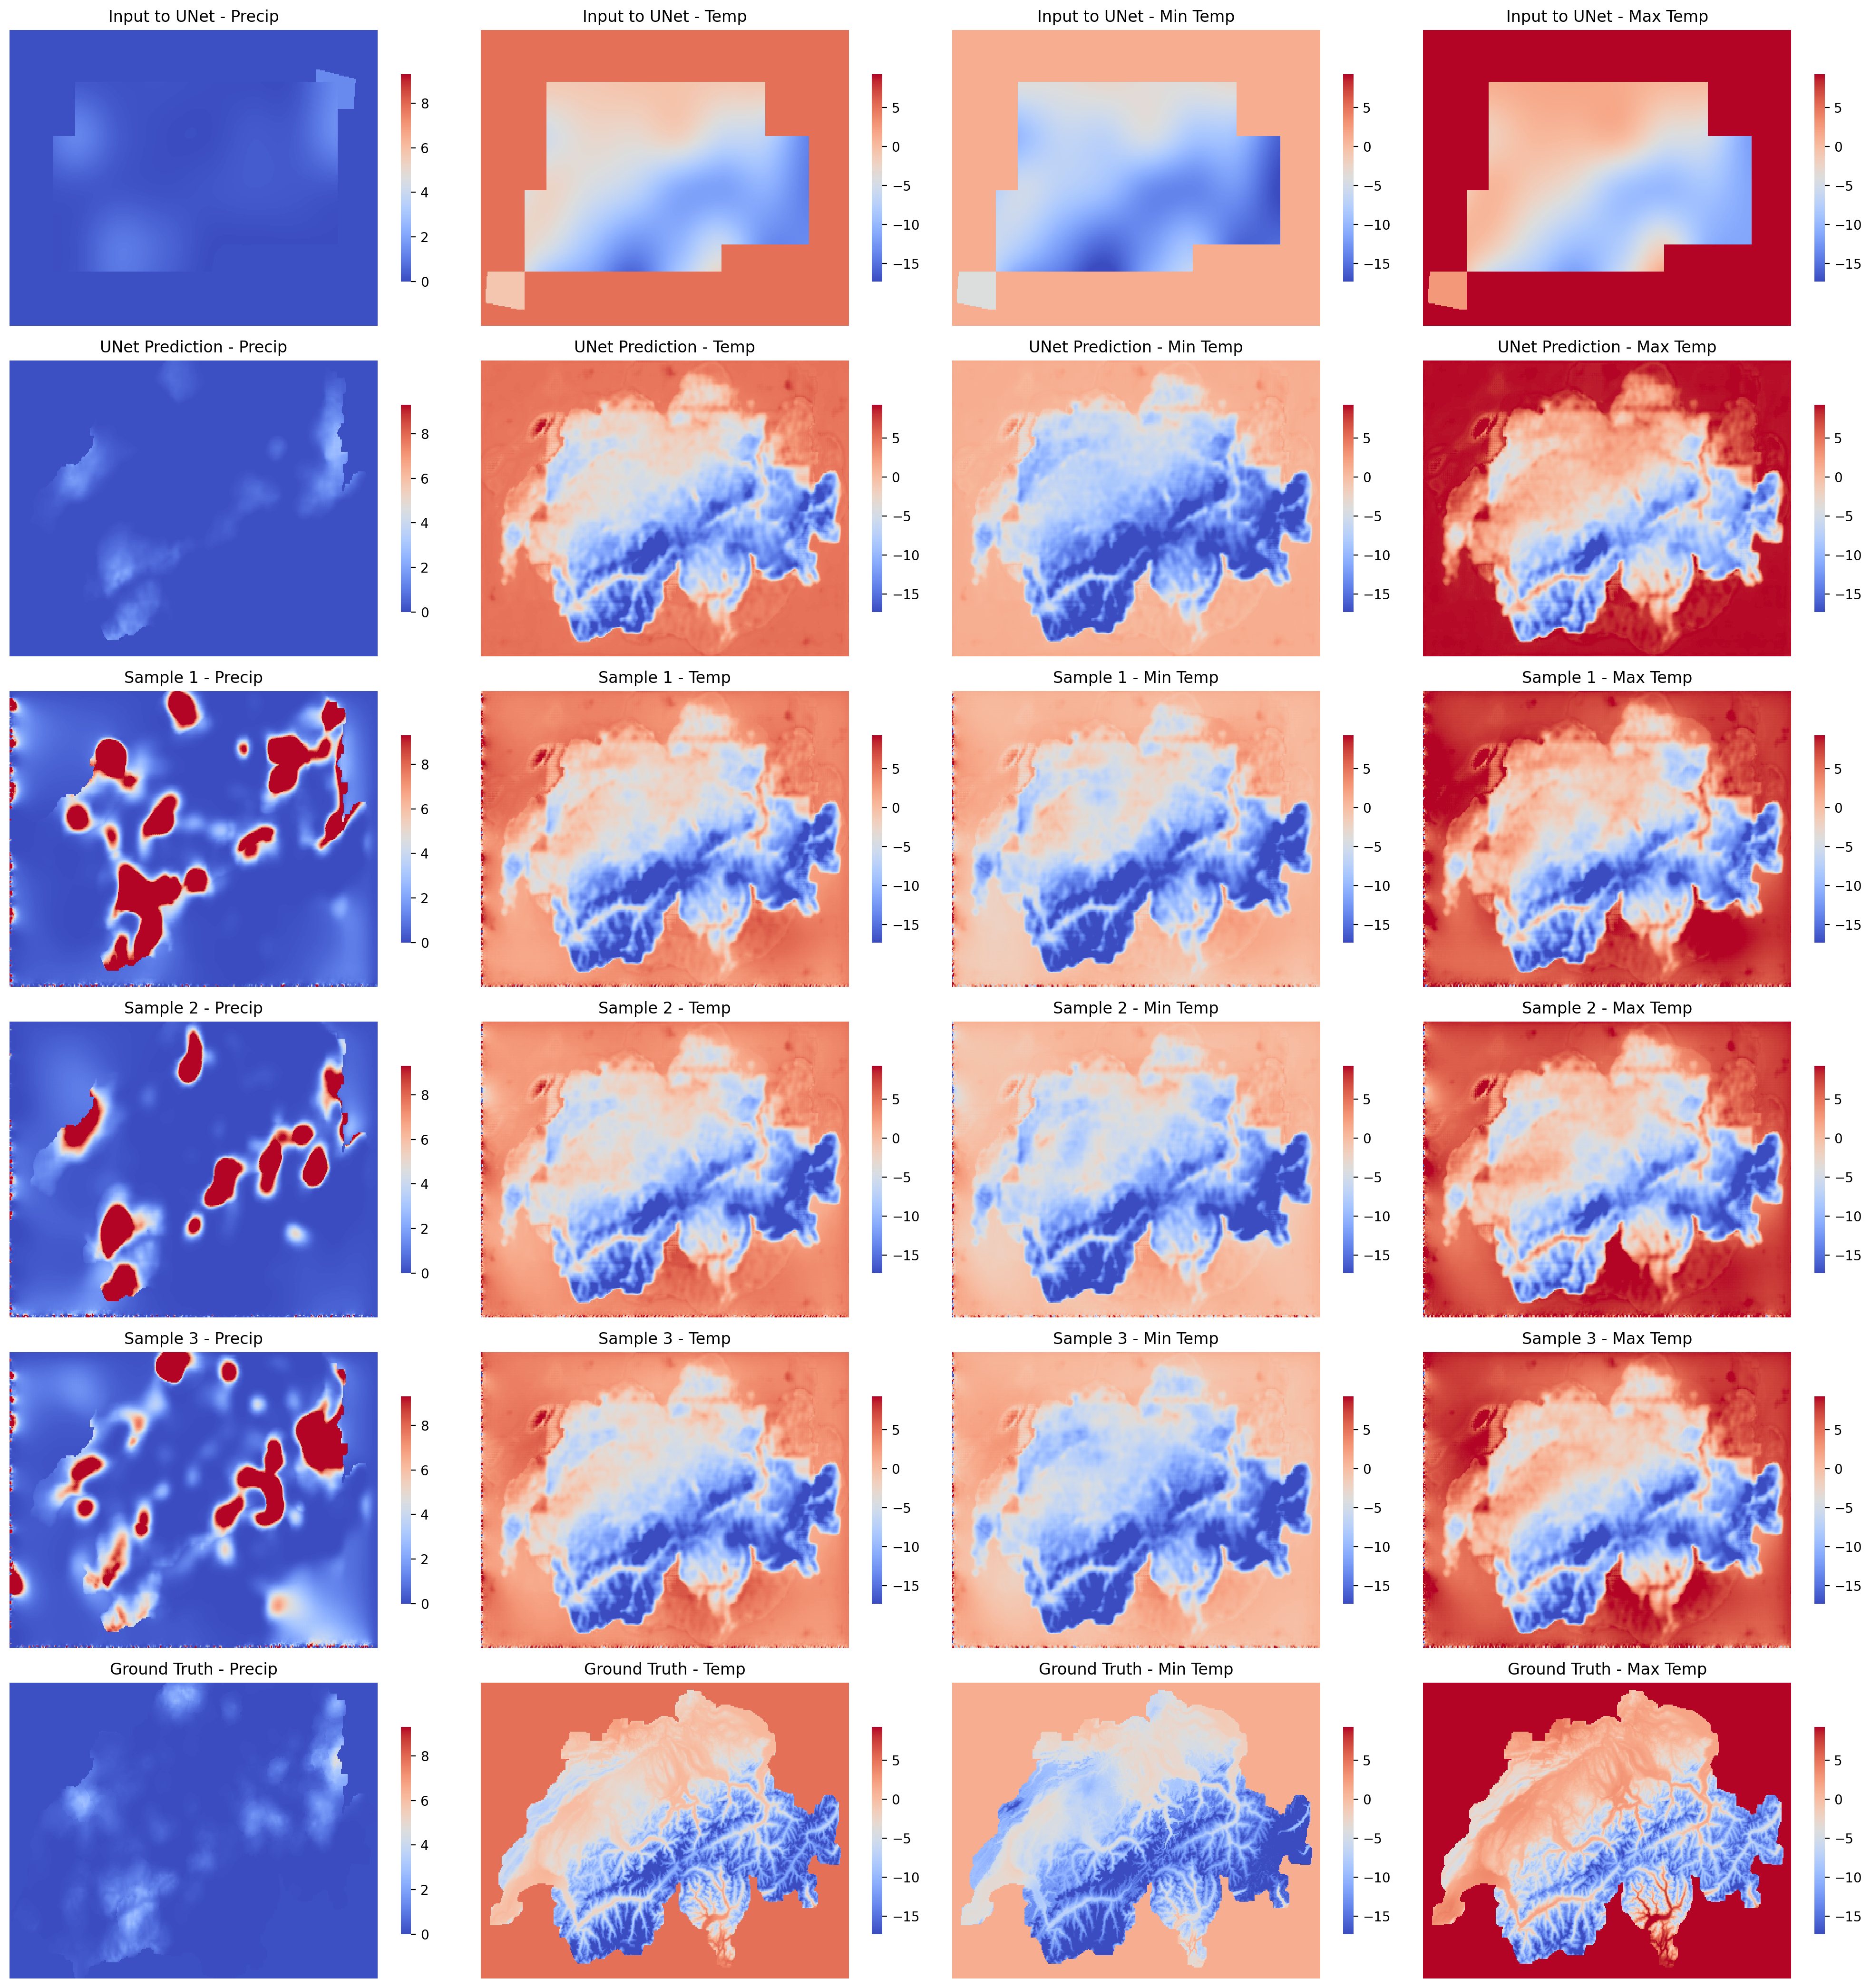

In [27]:
denorm_plot_samples(results_list, input_sample, target_sample)

Calculating  residual plots

In [28]:
def plot_sample_residuals(results_list, target_sample):
    target_np = target_sample[0].cpu().numpy()
    n_vars = 4
    n_samples = len(results_list)
    channel_names = ["Precip", "Temp", "Min Temp", "Max Temp"]

    # Denormalize ground truth
    target_denorm = np.empty_like(target_np)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params),
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            target_denorm[i] = denorm_pr(target_np[i])
        else:
            target_denorm[i] = denorm_temp(target_np[i],params)

    mask = np.any(np.isnan(target_np), axis=0)

    # Predictions: UNet + samples
    preds = []
    # UNet prediction
    unet_np = results_list[0]['unet_prediction'][0].cpu().numpy()
    unet_denorm = np.empty_like(unet_np)
    for j in range(n_vars):
        if channel_names[j].lower().startswith("precip"):
            unet_denorm[j] = np.clip(denorm_pr(unet_np[j]), 0, None)
        else:
            params = [pr_params, temp_params, temp_min_params, temp_max_params][j]
            unet_denorm[j] = denorm_temp(unet_np[j], params)
    preds.append(unet_denorm)

    # Generated Samples
    for results in results_list:
        final_np = results['final_prediction'][0].cpu().numpy()
        sample_denorm = np.empty_like(final_np)
        for j in range(n_vars):
            if channel_names[j].lower().startswith("precip"):
                sample_denorm[j] = np.clip(denorm_pr(final_np[j]), 0, None)
            else:
                params = [pr_params, temp_params, temp_min_params, temp_max_params][j]
                sample_denorm[j] = denorm_temp(final_np[j], params)
        preds.append(sample_denorm)

    # Residuals
    residuals = [pred - target_denorm for pred in preds]

    n_rows = n_samples + 1  # UNet + n_samples
    fig, axes = plt.subplots(n_rows, n_vars, figsize=(5 * n_vars, 3.5 * n_rows), dpi=200)
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    cmap.set_bad(color='white')

    all_residuals = np.stack(residuals)
    # Separate scales for precip and temperature residuals
    precip_residuals = all_residuals[..., 0, :, :]
    temp_residuals = all_residuals[..., 1:, :, :].reshape(-1, *all_residuals.shape[2:])

    vmin_precip = np.nanpercentile(precip_residuals, 2)
    vmax_precip = np.nanpercentile(precip_residuals, 98)
    vmin_temp = np.nanpercentile(temp_residuals, 2)
    vmax_temp = np.nanpercentile(temp_residuals, 98)

    for i in range(n_rows):
        for j in range(n_vars):
            arr = residuals[i][j].copy()
            arr[mask] = np.nan
            if n_rows == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            if j == 0:
                # Precipitation residuals: separate scale
                sns.heatmap(np.flipud(arr), ax=ax, cmap=cmap, vmin=vmin_precip, vmax=vmax_precip, cbar=True, cbar_kws={'shrink': 0.7})
            else:
                # Temperature residuals: common scale
                sns.heatmap(np.flipud(arr), ax=ax, cmap=cmap, vmin=vmin_temp, vmax=vmax_temp, cbar=True, cbar_kws={'shrink': 0.7})
            if i == 0:
                ax.set_title(f"UNet Residual - {channel_names[j]}")
            else:
                ax.set_title(f"Sample {i} Residual - {channel_names[j]}")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig("residuals_plot_single_frame.png", dpi=500)
    plt.show()

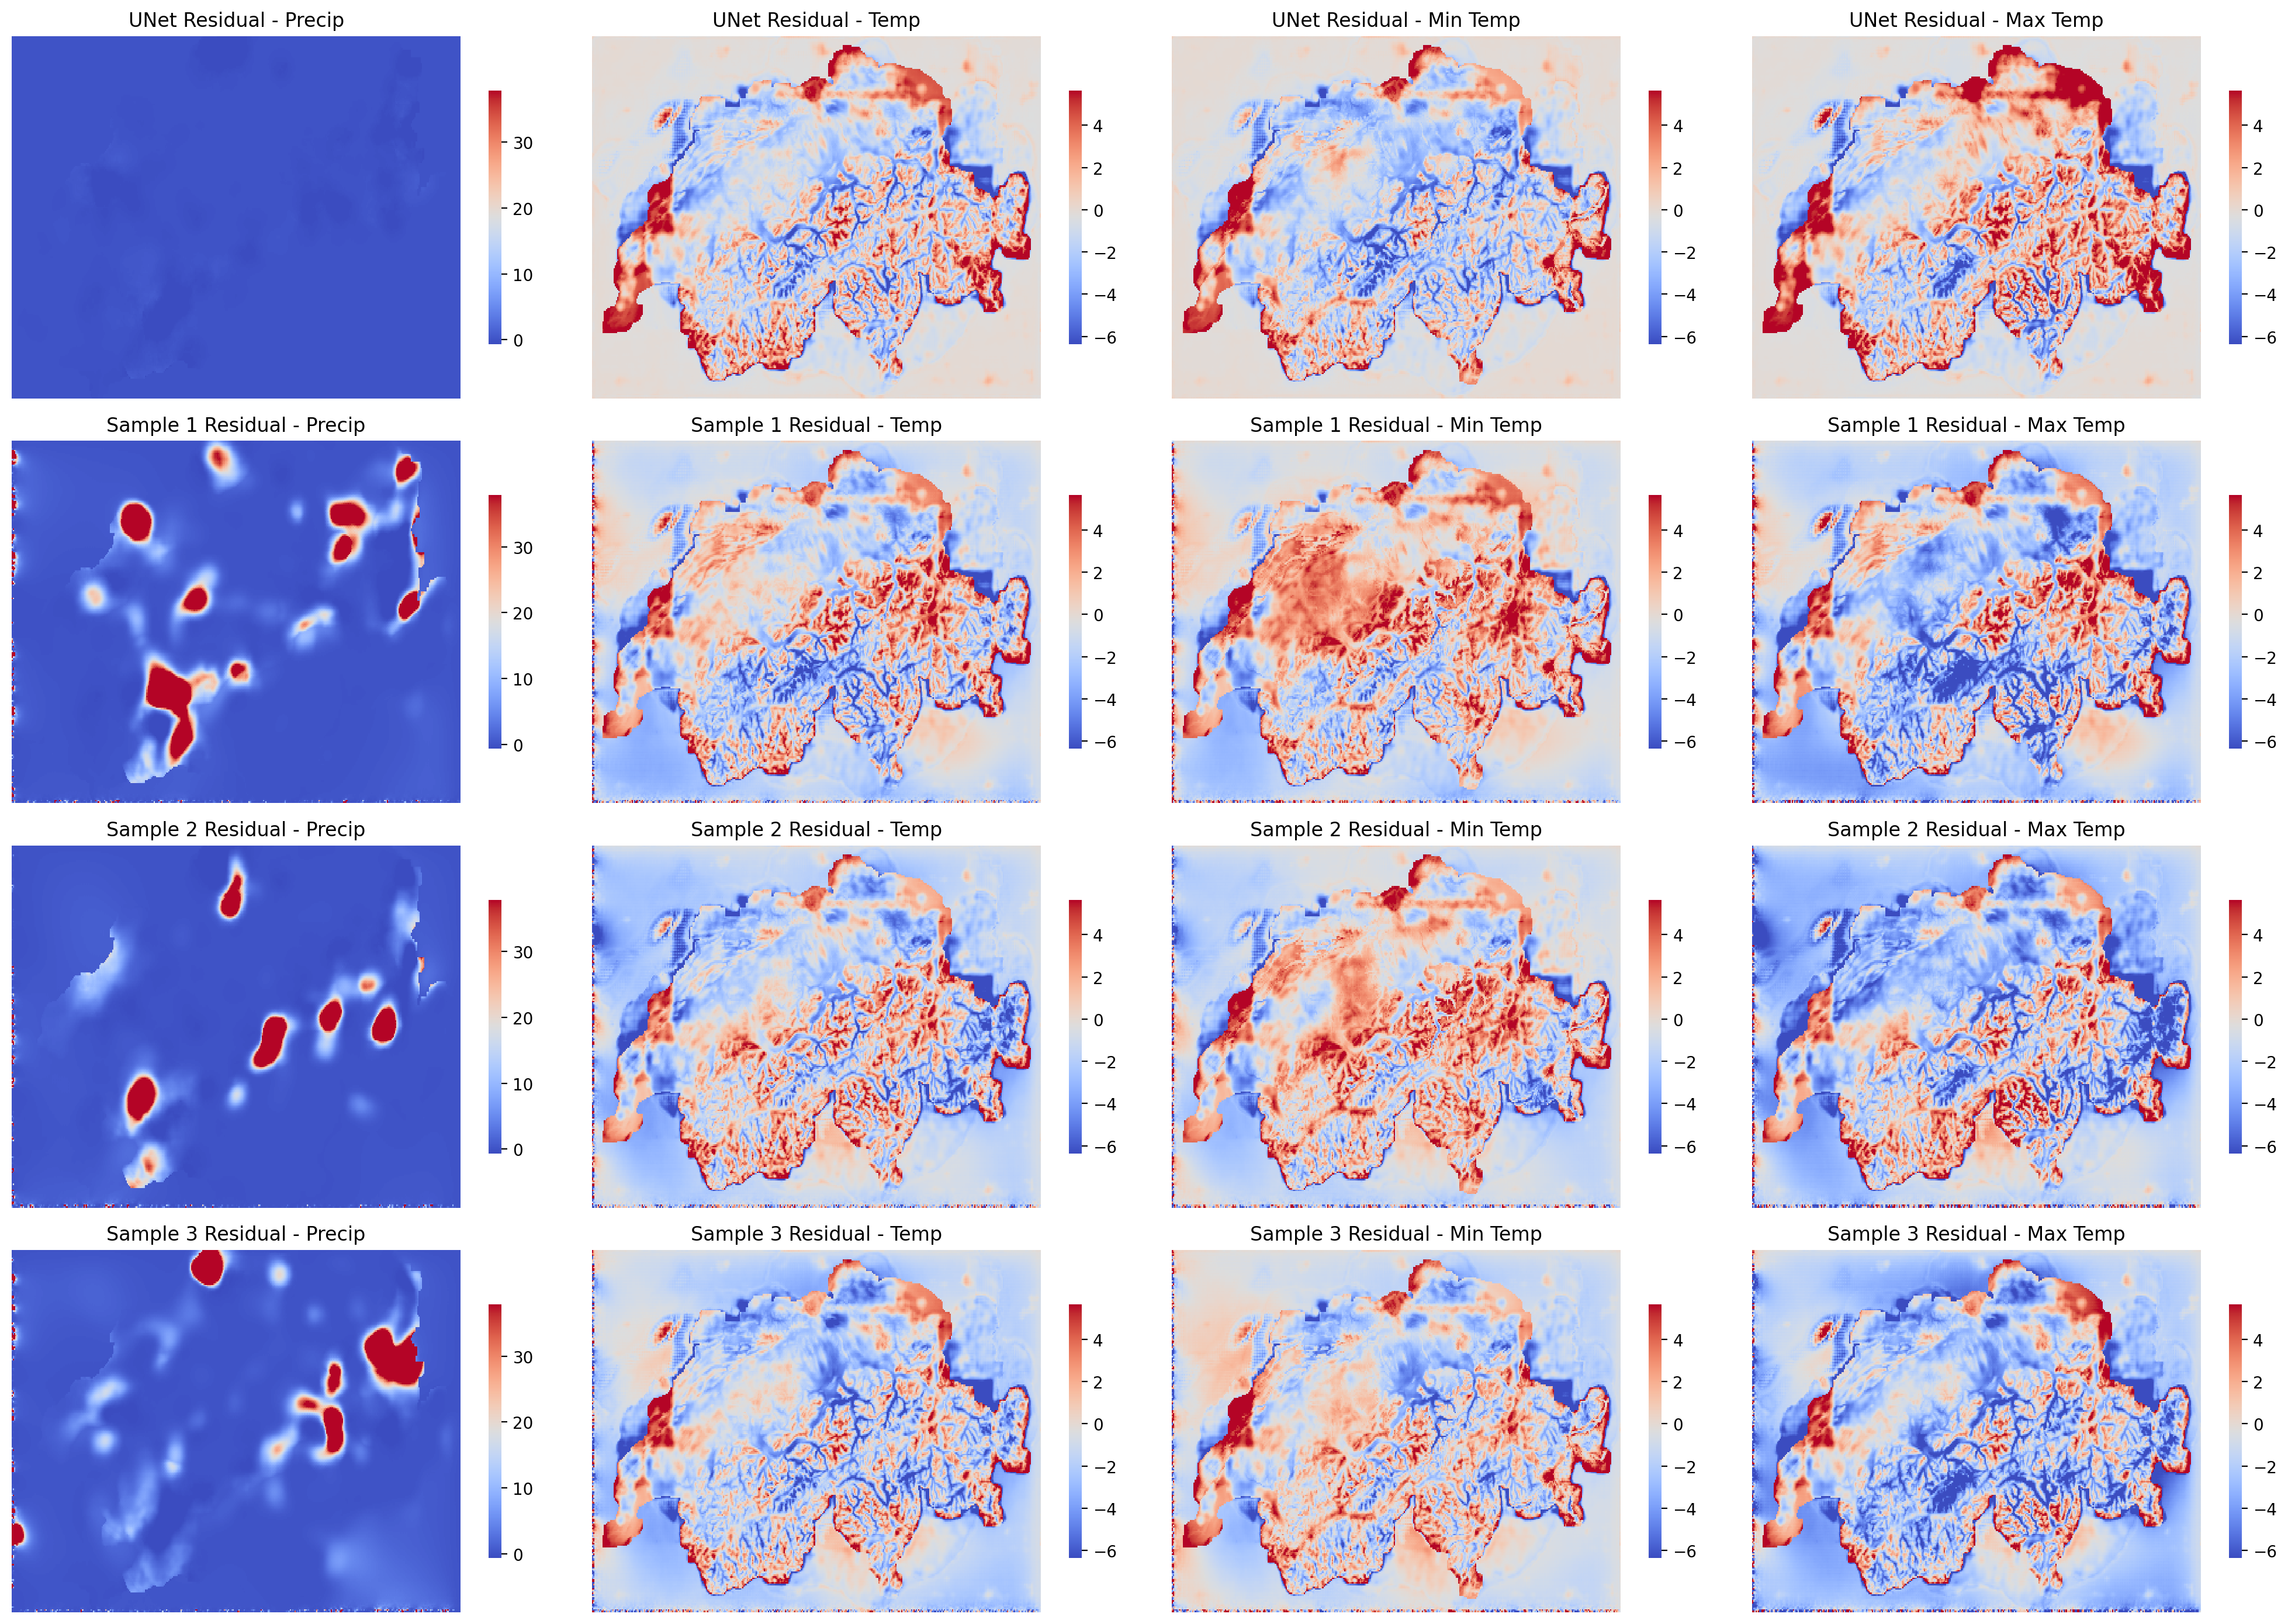

In [29]:
plot_sample_residuals(results_list, target_sample)